<a href="https://colab.research.google.com/github/moaamer2/color_unblind/blob/main/Models/Protanopia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io, os

# إعداد مجلد الإخراج
output_dir = "downloaded_images_p"
os.makedirs(output_dir, exist_ok=True)

# ID الفولدر (اللي فيه الصور)
folder_id = "1dcdU7wc3-7zXYpbaq_UYR6XJR29ZW3hr"

# إنشاء خدمة Google Drive
service = build('drive', 'v3')

# تحميل كل الملفات مع التصفح عبر الصفحات (pagination)
page_token = None
all_files = []

while True:
    response = service.files().list(
        q=f"'{folder_id}' in parents and mimeType contains 'image/' and trashed=false",
        fields="nextPageToken, files(id, name)",
        pageSize=1000,  # عدد الملفات في كل صفحة
        pageToken=page_token
    ).execute()

    all_files.extend(response.get('files', []))
    page_token = response.get('nextPageToken', None)

    if page_token is None:
        break  # خلاص مفيش صفحات تانية

print(f"📸 سيتم تحميل {len(all_files)} صورة من Google Drive...")

# تحميل الصور واحدة واحدة
for i, file in enumerate(all_files):
    file_id = file['id']
    file_name = file['name']
    file_path = os.path.join(output_dir, file_name)

    # تحميل الصورة
    request = service.files().get_media(fileId=file_id)
    fh = io.FileIO(file_path, 'wb')
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
        status, done = downloader.next_chunk()

    if (i + 1) % 50 == 0:
        print(f"✅ تم تحميل {i+1} صورة...")

print(f"🎉 تم تحميل {len(all_files)} صورة بنجاح!")


In [ ]:
# ======================================
# 📦 تثبيت المكتبات المطلوبة
# ======================================
!pip install --quiet daltonlens Pillow numpy

# ======================================
# 🧩 الاستيراد
# ======================================
import os
import numpy as np
from PIL import Image, UnidentifiedImageError
from daltonlens import simulate

# ======================================
# 🗂️ إعداد المسارات
# ======================================
input_dir = "downloaded_images_p"      # الصور الأصلية اللي اتحملت
output_dir = "pix2pix_pairs_p"         # فولدر الإخراج
os.makedirs(output_dir, exist_ok=True)

# ======================================
# 🧠 نوع عمى الألوان المستخدم (واحد فقط)
# ======================================
cvd_type = simulate.Deficiency.PROTAN  # Protanopia فقط
simulator = simulate.Simulator_Machado2009()

# ======================================
# 🎨 دالة التصحيح (Daltonization بسيطة)
# ======================================
def daltonize_simple(original, simulated):
    error = original.astype(int) - simulated.astype(int)
    corrected = original.astype(int) + error
    corrected = np.clip(corrected, 0, 255).astype("uint8")
    return corrected

# ======================================
# 🔁 المعالجة الكاملة — آمنة ومستمرة
# ======================================
count = 0
skipped = 0

for file_name in os.listdir(input_dir):
    if not file_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(input_dir, file_name)
    save_path = os.path.join(output_dir, file_name)

    # ✅ لو الصورة دي اتعملت قبل كده — تخطاها
    if os.path.exists(save_path):
        print(f"⏭️ تم تخطي {file_name} (موجودة بالفعل)")
        continue

    # ⚠️ محاولة فتح الصورة وتجنب الصور التالفة
    try:
        img = Image.open(img_path).convert("RGB").resize((256, 256))
    except UnidentifiedImageError:
        print(f"⚠️ الصورة {file_name} تالفة أو غير صالحة، تم تخطيها.")
        skipped += 1
        continue
    except Exception as e:
        print(f"⚠️ تخطيت {file_name} بسبب خطأ غير متوقع: {e}")
        skipped += 1
        continue

    img_np = np.asarray(img)

    # --- Simulation ---
    simulated = simulator.simulate_cvd(img_np, cvd_type, severity=1.0)
    sim_img = Image.fromarray(simulated.astype("uint8"))

    # --- Correction ---
    corrected = daltonize_simple(img_np, simulated)
    corr_img = Image.fromarray(corrected.astype("uint8"))

    # --- Combine pair (256x512) ---
    pair_img = Image.new("RGB", (512, 256))
    pair_img.paste(sim_img, (0, 0))
    pair_img.paste(corr_img, (256, 0))

    # --- Save output ---
    pair_img.save(save_path)
    count += 1

    if count % 50 == 0:
        print(f"✅ تمت معالجة {count} صورة...")

print(f"\n🎉 تم إنشاء {count} صور Pix2Pix بنجاح في المجلد: {output_dir}")
print(f"⚠️ تم تخطي {skipped} صورة تالفة أو مكررة.")
#ضغط و حفظ في الدرايف
from google.colab import drive
import shutil



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 1.4 MB/s eta 0:00:00
✅ تمت معالجة 50 صورة...
✅ تمت معالجة 100 صورة...
✅ تمت معالجة 150 صورة...
✅ تمت معالجة 200 صورة...
✅ تمت معالجة 250 صورة...
✅ تمت معالجة 300 صورة...
✅ تمت معالجة 350 صورة...
✅ تمت معالجة 400 صورة...
✅ تمت معالجة 450 صورة...
✅ تمت معالجة 500 صورة...
✅ تمت معالجة 550 صورة...
✅ تمت معالجة 600 صورة...
✅ تمت معالجة 650 صورة...
✅ تمت معالجة 700 صورة...
✅ تمت معالجة 750 صورة...
✅ تمت معالجة 800 صورة...
✅ تمت معالجة 850 صورة...
✅ تمت معالجة 900 صورة...
✅ تمت معالجة 950 صورة...
✅ تمت معالجة 1000 صورة...
✅ تمت معالجة 1050 صورة...
✅ تمت معالجة 1100 صورة...
✅ تمت معالجة 1150 صورة...
✅ تمت معالجة 1200 صورة...
✅ تمت معالجة 1250 صورة...
✅ تمت معالجة 1300 صورة...
✅ تمت معالجة 1350 صورة...
✅ تمت معالجة 1400 صورة...
✅ تمت معالجة 1450 صورة...
✅ تمت معالجة 1500 صورة...
✅ تمت معالجة 1550 صورة...
✅ تمت معالجة 1600 صورة...
✅ تمت معالجة 1650 صورة...
✅ تمت معالجة 1700 صورة...
✅ تمت معالجة 1750 صورة...
✅ تمت معالجة 1800 صورة...
✅ تمت 

ValueError: mount failed

In [ ]:
# 1️⃣ ربط Google Drive
drive.mount('/content/drive')
# 2️⃣ إنشاء ملف ZIP للفولدر
zip_path = shutil.make_archive("pix2pix_pairs_p", 'zip', "pix2pix_pairs_p")
print("📦 تم ضغط المجلد إلى:", zip_path)

# 3️⃣ نسخ الملف المضغوط إلى Drive
!cp pix2pix_pairs_p.zip "/content/drive/MyDrive/pix2pix_pairs_p.zip"

print("✅ تم حفظ الملف المضغوط في Google Drive داخل MyDrive باسم 'pix2pix_pairs_p.zip'")

Mounted at /content/drive
📦 تم ضغط المجلد إلى: /content/pix2pix_pairs_p.zip
✅ تم حفظ الملف المضغوط في Google Drive داخل MyDrive باسم 'pix2pix_pairs_p.zip'


In [ ]:
# ======================================
# 📂 جلب الملف المضغوط من Google Drive وفك الضغط
# ======================================

from google.colab import drive
import zipfile
import os

# 1️⃣ ربط Google Drive
drive.mount('/content/drive')

# 2️⃣ تحديد مسار الملف في Drive
zip_path = "/content/drive/MyDrive/pix2pix_pairs_p.zip"

# 3️⃣ تحديد مجلد الاستخراج
extract_dir = "/content/pix2pix_pairs_p"
os.makedirs(extract_dir, exist_ok=True)

# 4️⃣ فك الضغط
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ تم فك الضغط بنجاح! المجلد متاح الآن في: {extract_dir}")


Mounted at /content/drive
✅ تم فك الضغط بنجاح! المجلد متاح الآن في: /content/pix2pix_pairs_p


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# المسار للفولدر اللي فيه الصور المزدوجة
dataset_dir = "/content/pix2pix_pairs_p"
train_dir = "/content/pix2pix_dataset_p/train"
test_dir = "/content/pix2pix_dataset_p/test"

# إنشاء الفولدرات لو مش موجودة
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# قراءة كل أسماء الصور
all_images = [f for f in os.listdir(dataset_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# تقسيم Train/Test بنسبة 80% - 20%
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

# نسخ الملفات إلى الفولدرات الجديدة
for file in train_files:
    shutil.copy(os.path.join(dataset_dir, file), os.path.join(train_dir, file))

for file in test_files:
    shutil.copy(os.path.join(dataset_dir, file), os.path.join(test_dir, file))

print(f"✅ تم التقسيم بنجاح:")
print(f"- عدد صور التدريب: {len(train_files)}")
print(f"- عدد صور الاختبار: {len(test_files)}")


✅ تم التقسيم بنجاح:
- عدد صور التدريب: 6548
- عدد صور الاختبار: 1638


In [ ]:
# train_improved_pytorch_drive.py
# نسخة محسّنة من تدريب Pix2Pix بـ PyTorch مع حفظ تلقائي على Google Drive
# يشمل تحسينات على الأداء، Augmentations إضافية، وحفظ النتائج بشكل آمن

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image
import shutil
from google.colab import drive

# ---------------- Google Drive Setup ----------------
drive.mount('/content/drive')
GDRIVE_DIR = "/content/drive/MyDrive/pix2pix_result_p"
os.makedirs(GDRIVE_DIR, exist_ok=True)

# ---------------- Configuration ----------------
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Paths
TRAIN_DIR = "/content/pix2pix_dataset_p/train"
VAL_DIR = None  # ضع فولدر فاليديشن لو عندك
OUTPUT_DIR = "/content/pix2pix_dataset_p/out"
os.makedirs(OUTPUT_DIR, exist_ok=True)
SAMPLES_DIR = os.path.join(OUTPUT_DIR, "Evaluation")
os.makedirs(SAMPLES_DIR, exist_ok=True)

CHECKPOINT_GEN = os.path.join(OUTPUT_DIR, "gen_best_p.pth.tar")
CHECKPOINT_DISC = os.path.join(OUTPUT_DIR, "disc_best_p.pth.tar")

# Hyperparams
BATCH_SIZE = 4
NUM_WORKERS = min(os.cpu_count(), 4)
IMAGE_SIZE = 256
CHANNELS_IMG = 3
LEARNING_RATE = 2e-4
L1_LAMBDA = 100
NUM_EPOCHS = 100
USE_MIXED_PRECISION = True
SAVE_EVERY = 5
THRESH_DIFF = 0.03

# ---------------- Dataset ----------------
class MapDataset(Dataset):
    def __init__(self, root_dir, image_size=IMAGE_SIZE, is_train=True):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.is_train = is_train
        self.image_size = image_size

        # Augmentations
        if self.is_train:
            self.both = A.Compose([
                A.Resize(286,286),
                A.RandomCrop(image_size,image_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.HueSaturationValue(p=0.3)
            ], additional_targets={"image0":"image"})
        else:
            self.both = A.Compose([A.Resize(image_size,image_size)], additional_targets={"image0":"image"})

        self.to_tensor = A.Compose([
            A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), max_pixel_value=255.0),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        augmented = self.both(image=input_image, image0=target_image)
        inp = self.to_tensor(image=augmented["image"])["image"]
        tar = self.to_tensor(image=augmented["image0"])["image"]
        return inp, tar

# ---------------- Models ----------------
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_instancenorm=True):
        super().__init__()
        norm = nn.InstanceNorm2d if use_instancenorm else nn.BatchNorm2d
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 2, stride=stride, bias=False),
            norm(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self,in_channels=3, features=(64,128,256,512), use_instancenorm=True):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        layers=[]
        in_ch = features[0]
        for feature in features[1:]:
            stride = 1 if feature == features[-1] else 2
            layers.append(CNNBlock(in_ch, feature, stride=stride, use_instancenorm=use_instancenorm))
            in_ch = feature
        layers.append(nn.Conv2d(in_ch,1,4,1,1))
        self.model = nn.Sequential(*layers)

    def forward(self,x,y):
        xy = torch.cat([x,y],dim=1)
        out = self.initial(xy)
        out = self.model(out)
        return out

class U_NetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False,use_instancenorm=True):
        super().__init__()
        norm = nn.InstanceNorm2d if use_instancenorm else nn.BatchNorm2d
        if down:
            layers=[
                nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode="reflect"),
                norm(out_channels),
                nn.LeakyReLU(0.2) if act=="leaky" else nn.ReLU()
            ]
        else:
            layers=[
                nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
                norm(out_channels),
                nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2)
            ]
        self.conv = nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64, use_instancenorm=True):
        super().__init__()
        self.initial_down = nn.Sequential(nn.Conv2d(in_channels,features,4,2,1), nn.LeakyReLU(0.2))
        self.down1 = U_NetBlock(features,features*2,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down2 = U_NetBlock(features*2,features*4,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down3 = U_NetBlock(features*4,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down4 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down5 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down6 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.bottleneck = nn.Sequential(nn.Conv2d(features*8,features*8,4,2,1), nn.ReLU())
        self.up1 = U_NetBlock(features*8,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up2 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up3 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up4 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up5 = U_NetBlock(features*8*2,features*4,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up6 = U_NetBlock(features*4*2,features*2,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up7 = U_NetBlock(features*2*2,features,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.final_up = nn.Sequential(nn.ConvTranspose2d(features*2,in_channels,4,2,1), nn.Tanh())

    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Utilities ----------------
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print(f"=> Saved checkpoint: {filename}")
    shutil.copy(filename, GDRIVE_DIR)
    print(f"=> Copied checkpoint to Google Drive: {GDRIVE_DIR}")

def compute_diff_count(y_true, y_pred, thresh=THRESH_DIFF):
    with torch.no_grad():
        diff = torch.abs(y_true - y_pred)
        diff_gray = diff.mean(dim=1)
        mask = diff_gray > thresh
        counts = torch.count_nonzero(mask, dim=(1,2)).cpu().numpy()
    return counts

# ---------------- Training Loop ----------------
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss_fn, bce_loss_fn, g_scaler, d_scaler):
    disc.train(); gen.train()
    loop = tqdm(loader, leave=False)
    avg_d_loss=0; avg_g_loss=0; n=0
    for x,y in loop:
        x,y = x.to(DEVICE), y.to(DEVICE); n+=1
        # Discriminator
        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            y_fake = gen(x)
            D_real = disc(x,y)
            D_fake = disc(x,y_fake.detach())
            D_loss = 0.5*(bce_loss_fn(D_real,torch.ones_like(D_real)) + bce_loss_fn(D_fake,torch.zeros_like(D_fake)))
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc); d_scaler.update()
        # Generator
        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            D_fake_for_g = disc(x,y_fake)
            G_loss = bce_loss_fn(D_fake_for_g,torch.ones_like(D_fake_for_g)) + L1_LAMBDA*l1_loss_fn(y_fake,y)
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen); g_scaler.update()
        avg_d_loss += D_loss.item(); avg_g_loss += G_loss.item()
        if n%50==0: loop.set_postfix({'D_loss':D_loss.item(),'G_loss':G_loss.item()})
    return avg_d_loss/n, avg_g_loss/n

def evaluate_on_val(gen,val_loader,l1_loss_fn,num_batches=3):
    gen.eval(); total=0; count=0
    with torch.no_grad():
        for i,(x,y) in enumerate(val_loader):
            x,y = x.to(DEVICE), y.to(DEVICE)
            y_fake = gen(x)
            total += l1_loss_fn(y_fake,y).item(); count+=1
            if i+1>=num_batches: break
    gen.train()
    return total/count if count>0 else 1e9

# ---------------- Main ----------------
def main():
    train_dataset = MapDataset(TRAIN_DIR,is_train=True)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True,drop_last=True)
    val_loader = train_loader if VAL_DIR is None else DataLoader(MapDataset(VAL_DIR,is_train=False),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,pin_memory=True)

    disc = Discriminator(in_channels=CHANNELS_IMG).to(DEVICE)
    gen = Generator(in_channels=CHANNELS_IMG).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
    opt_gen = optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
    BCE = nn.BCEWithLogitsLoss(); L1_LOSS = nn.L1Loss()
    g_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
    d_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)

    G_losses=[]; D_losses=[]; val_l1_history=[]; best_val_l1=float('inf')

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        d_loss_avg, g_loss_avg = train_fn(disc,gen,train_loader,opt_disc,opt_gen,L1_LOSS,BCE,g_scaler,d_scaler)
        val_l1 = evaluate_on_val(gen,val_loader,L1_LOSS)
        print(f"Train D_loss: {d_loss_avg:.4f}, G_loss: {g_loss_avg:.4f} | Val L1 (est): {val_l1:.6f}")

        D_losses.append(d_loss_avg); G_losses.append(g_loss_avg); val_l1_history.append(val_l1)
        # save CSV logs
        for name, arr in [("D_losses.csv",D_losses),("G_losses.csv",G_losses),("val_l1.csv",val_l1_history)]:
            path = os.path.join(OUTPUT_DIR,name)
            np.savetxt(path,np.array(arr),delimiter=",",fmt="%.6f")
            shutil.copy(path,GDRIVE_DIR)

        # save best checkpoints
        if val_l1<best_val_l1:
            best_val_l1=val_l1
            save_checkpoint({"state_dict":gen.state_dict(),"optimizer":opt_gen.state_dict(),"epoch":epoch,"val_l1":val_l1},CHECKPOINT_GEN)
            save_checkpoint({"state_dict":disc.state_dict(),"optimizer":opt_disc.state_dict(),"epoch":epoch,"val_l1":val_l1},CHECKPOINT_DISC)

        # save sample images
        if (epoch+1)%SAVE_EVERY==0:
            gen.eval()
            with torch.no_grad():
                x_sample,y_sample = next(iter(val_loader))
                x_sample,y_sample = x_sample.to(DEVICE),y_sample.to(DEVICE)
                y_fake = gen(x_sample)
                B = min(4,x_sample.shape[0])
                for i in range(B):
                    for name,img in zip(["input","target","gen"],[(x_sample[i]*0.5+0.5),(y_sample[i]*0.5+0.5),(y_fake[i]*0.5+0.5)]):
                        file_path = os.path.join(SAMPLES_DIR,f"epoch{epoch+1}_{name}_{i}.png")
                        save_image(img.clamp(0,1),file_path)
                        shutil.copy(file_path,GDRIVE_DIR)
            gen.train()

    # save final model
    save_checkpoint({"state_dict":gen.state_dict(),"optimizer":opt_gen.state_dict(),"epoch":NUM_EPOCHS-1,"val_l1":best_val_l1},
                    os.path.join(OUTPUT_DIR,"gen_final_p.pth.tar"))

if __name__=="__main__":
    main()


In [ ]:
# لتكمله التدريب القديم
# train_improved_pytorch_drive_resume.py
# نسخة محسّنة مع دعم استئناف التدريب من آخر Checkpoint محفوظ على Google Drive

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image
import shutil
from google.colab import drive

# ---------------- Google Drive Setup ----------------
drive.mount('/content/drive')
GDRIVE_DIR = "/content/drive/MyDrive/pix2pix_result_p"
os.makedirs(GDRIVE_DIR, exist_ok=True)

# ---------------- Configuration ----------------
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Paths
TRAIN_DIR = "/content/pix2pix_dataset_p/train"
VAL_DIR = None  # ضع فولدر فاليديشن لو عندك
OUTPUT_DIR = "/content/pix2pix_dataset_p/out"
os.makedirs(OUTPUT_DIR, exist_ok=True)
SAMPLES_DIR = os.path.join(OUTPUT_DIR, "Evaluation")
os.makedirs(SAMPLES_DIR, exist_ok=True)

# ملفات الـ checkpoint (يمكن تعديل الأسماء لو عندك أسماء تانية)
CHECKPOINT_GEN = os.path.join(OUTPUT_DIR, "gen_best_p.pth.tar")
CHECKPOINT_DISC = os.path.join(OUTPUT_DIR, "disc_best_p.pth.tar")
# نسخ في Drive (save_checkpoint سيقوم بنسخها تلقائياً لـ GDRIVE_DIR)

# Hyperparams
BATCH_SIZE = 4
NUM_WORKERS = min(os.cpu_count(), 4)
IMAGE_SIZE = 256
CHANNELS_IMG = 3
LEARNING_RATE = 2e-4
L1_LAMBDA = 100
NUM_EPOCHS = 100
USE_MIXED_PRECISION = True
SAVE_EVERY = 5
THRESH_DIFF = 0.03

# ---------------- Dataset ----------------
class MapDataset(Dataset):
    def __init__(self, root_dir, image_size=IMAGE_SIZE, is_train=True):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.is_train = is_train
        self.image_size = image_size

        # Augmentations
        if self.is_train:
            self.both = A.Compose([
                A.Resize(286,286),
                A.RandomCrop(image_size,image_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.HueSaturationValue(p=0.3)
            ], additional_targets={"image0":"image"})
        else:
            self.both = A.Compose([A.Resize(image_size,image_size)], additional_targets={"image0":"image"})

        self.to_tensor = A.Compose([
            A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), max_pixel_value=255.0),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        augmented = self.both(image=input_image, image0=target_image)
        inp = self.to_tensor(image=augmented["image"])["image"]
        tar = self.to_tensor(image=augmented["image0"])["image"]
        return inp, tar

# ---------------- Models ----------------
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_instancenorm=True):
        super().__init__()
        norm = nn.InstanceNorm2d if use_instancenorm else nn.BatchNorm2d
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 2, stride=stride, bias=False),
            norm(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self,in_channels=3, features=(64,128,256,512), use_instancenorm=True):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        layers=[]
        in_ch = features[0]
        for feature in features[1:]:
            stride = 1 if feature == features[-1] else 2
            layers.append(CNNBlock(in_ch, feature, stride=stride, use_instancenorm=use_instancenorm))
            in_ch = feature
        layers.append(nn.Conv2d(in_ch,1,4,1,1))
        self.model = nn.Sequential(*layers)

    def forward(self,x,y):
        xy = torch.cat([x,y],dim=1)
        out = self.initial(xy)
        out = self.model(out)
        return out

class U_NetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False,use_instancenorm=True):
        super().__init__()
        norm = nn.InstanceNorm2d if use_instancenorm else nn.BatchNorm2d
        if down:
            layers=[
                nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode="reflect"),
                norm(out_channels),
                nn.LeakyReLU(0.2) if act=="leaky" else nn.ReLU()
            ]
        else:
            layers=[
                nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
                norm(out_channels),
                nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2)
            ]
        self.conv = nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64, use_instancenorm=True):
        super().__init__()
        self.initial_down = nn.Sequential(nn.Conv2d(in_channels,features,4,2,1), nn.LeakyReLU(0.2))
        self.down1 = U_NetBlock(features,features*2,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down2 = U_NetBlock(features*2,features*4,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down3 = U_NetBlock(features*4,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down4 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down5 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.down6 = U_NetBlock(features*8,features*8,down=True,act="leaky",use_instancenorm=use_instancenorm)
        self.bottleneck = nn.Sequential(nn.Conv2d(features*8,features*8,4,2,1), nn.ReLU())
        self.up1 = U_NetBlock(features*8,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up2 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up3 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True,use_instancenorm=use_instancenorm)
        self.up4 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up5 = U_NetBlock(features*8*2,features*4,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up6 = U_NetBlock(features*4*2,features*2,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.up7 = U_NetBlock(features*2*2,features,down=False,act="relu",use_instancenorm=use_instancenorm)
        self.final_up = nn.Sequential(nn.ConvTranspose2d(features*2,in_channels,4,2,1), nn.Tanh())

    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Utilities ----------------
def save_checkpoint(state, filename):
    """
    state: dict containing at least 'state_dict' and optionally 'optimizer', 'epoch', 'val_l1', 'g_scaler', 'd_scaler'
    """
    torch.save(state, filename)
    print(f"=> Saved checkpoint: {filename}")
    # also copy to Google Drive folder
    try:
        shutil.copy(filename, GDRIVE_DIR)
        print(f"=> Copied checkpoint to Google Drive: {GDRIVE_DIR}")
    except Exception as e:
        print(f"⚠️ Could not copy checkpoint to Drive: {e}")

def compute_diff_count(y_true, y_pred, thresh=THRESH_DIFF):
    with torch.no_grad():
        diff = torch.abs(y_true - y_pred)
        diff_gray = diff.mean(dim=1)
        mask = diff_gray > thresh
        counts = torch.count_nonzero(mask, dim=(1,2)).cpu().numpy()
    return counts

# ---------------- Training Loop ----------------
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss_fn, bce_loss_fn, g_scaler, d_scaler):
    disc.train(); gen.train()
    loop = tqdm(loader, leave=False)
    avg_d_loss=0; avg_g_loss=0; n=0
    for x,y in loop:
        x,y = x.to(DEVICE), y.to(DEVICE); n+=1
        # Discriminator
        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            y_fake = gen(x)
            D_real = disc(x,y)
            D_fake = disc(x,y_fake.detach())
            D_loss = 0.5*(bce_loss_fn(D_real,torch.ones_like(D_real)) + bce_loss_fn(D_fake,torch.zeros_like(D_fake)))
        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc); d_scaler.update()
        # Generator
        with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
            D_fake_for_g = disc(x,y_fake)
            G_loss = bce_loss_fn(D_fake_for_g,torch.ones_like(D_fake_for_g)) + L1_LAMBDA*l1_loss_fn(y_fake,y)
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen); g_scaler.update()
        avg_d_loss += D_loss.item(); avg_g_loss += G_loss.item()
        if n%50==0: loop.set_postfix({'D_loss':D_loss.item(),'G_loss':G_loss.item()})
    return avg_d_loss/n, avg_g_loss/n

def evaluate_on_val(gen,val_loader,l1_loss_fn,num_batches=3):
    gen.eval(); total=0; count=0
    with torch.no_grad():
        for i,(x,y) in enumerate(val_loader):
            x,y = x.to(DEVICE), y.to(DEVICE)
            y_fake = gen(x)
            total += l1_loss_fn(y_fake,y).item(); count+=1
            if i+1>=num_batches: break
    gen.train()
    return total/count if count>0 else 1e9

# ---------------- Main ----------------
def main():
    train_dataset = MapDataset(TRAIN_DIR,is_train=True)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True,drop_last=True)
    val_loader = train_loader if VAL_DIR is None else DataLoader(MapDataset(VAL_DIR,is_train=False),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,pin_memory=True)

    disc = Discriminator(in_channels=CHANNELS_IMG).to(DEVICE)
    gen = Generator(in_channels=CHANNELS_IMG).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
    opt_gen = optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
    BCE = nn.BCEWithLogitsLoss(); L1_LOSS = nn.L1Loss()
    g_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
    d_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)

    # History + resume vars
    G_losses=[]; D_losses=[]; val_l1_history=[]
    best_val_l1=float('inf')
    start_epoch = 0

    # ----- Try to find checkpoint in Drive first, then local OUTPUT_DIR -----
    def try_load_checkpoint(path):
        if not os.path.exists(path):
            return None
        try:
            ckpt = torch.load(path, map_location=DEVICE)
            return ckpt
        except Exception as e:
            print(f"⚠️ Error loading checkpoint {path}: {e}")
            return None

    # search locations
    possible_gen_paths = [
        os.path.join(GDRIVE_DIR, os.path.basename(CHECKPOINT_GEN)),  # Drive copy
        CHECKPOINT_GEN  # local
    ]
    possible_disc_paths = [
        os.path.join(GDRIVE_DIR, os.path.basename(CHECKPOINT_DISC)),
        CHECKPOINT_DISC
    ]

    # load generator checkpoint if found
    ckpt_g = None
    for p in possible_gen_paths:
        ckpt_g = try_load_checkpoint(p)
        if ckpt_g is not None:
            print(f"=> Loaded generator checkpoint from: {p}")
            break

    if ckpt_g is not None:
        # load weights
        if 'state_dict' in ckpt_g:
            try:
                gen.load_state_dict(ckpt_g['state_dict'])
                print("   ✅ Generator weights loaded")
            except Exception as e:
                print(f"   ⚠️ Could not load generator weights: {e}")

        # load optimizer state if present
        if 'optimizer' in ckpt_g:
            try:
                opt_gen.load_state_dict(ckpt_g['optimizer'])
                print("   ✅ Generator optimizer state loaded")
            except Exception as e:
                print(f"   ⚠️ Could not load generator optimizer state: {e}")

        # load grad scaler state if present
        if 'g_scaler' in ckpt_g:
            try:
                g_scaler.load_state_dict(ckpt_g['g_scaler'])
                print("   ✅ Generator GradScaler state loaded")
            except Exception as e:
                print(f"   ⚠️ Could not load g_scaler state: {e}")

        saved_epoch = ckpt_g.get('epoch', None)
        if saved_epoch is not None:
            start_epoch = saved_epoch + 1
            print(f"   ▶ Will resume training from epoch {start_epoch} (saved epoch = {saved_epoch})")

        best_val_l1 = ckpt_g.get('val_l1', best_val_l1)

    # load discriminator checkpoint if found
    ckpt_d = None
    for p in possible_disc_paths:
        ckpt_d = try_load_checkpoint(p)
        if ckpt_d is not None:
            print(f"=> Loaded discriminator checkpoint from: {p}")
            break

    if ckpt_d is not None:
        if 'state_dict' in ckpt_d:
            try:
                disc.load_state_dict(ckpt_d['state_dict'])
                print("   ✅ Discriminator weights loaded")
            except Exception as e:
                print(f"   ⚠️ Could not load discriminator weights: {e}")

        if 'optimizer' in ckpt_d:
            try:
                opt_disc.load_state_dict(ckpt_d['optimizer'])
                print("   ✅ Discriminator optimizer state loaded")
            except Exception as e:
                print(f"   ⚠️ Could not load discriminator optimizer state: {e}")

        if 'd_scaler' in ckpt_d:
            try:
                d_scaler.load_state_dict(ckpt_d['d_scaler'])
                print("   ✅ Discriminator GradScaler state loaded")
            except Exception as e:
                print(f"   ⚠️ Could not load d_scaler state: {e}")

    # ----- Try to load CSV logs (history) from OUTPUT_DIR or GDRIVE_DIR -----
    for name, arr in [("D_losses.csv", D_losses), ("G_losses.csv", G_losses), ("val_l1.csv", val_l1_history)]:
        path_local = os.path.join(OUTPUT_DIR, name)
        path_drive = os.path.join(GDRIVE_DIR, name)
        loaded = False
        for path_try in [path_local, path_drive]:
            if os.path.exists(path_try):
                try:
                    data = np.loadtxt(path_try, delimiter=",")
                    if data.ndim == 0:
                        data = np.array([data])
                    arr.extend(data.tolist())
                    print(f"✅ Loaded {len(data)} entries from {path_try}")
                    loaded = True
                    break
                except Exception as e:
                    print(f"⚠️ Couldn't read {path_try}: {e}")
        if not loaded:
            # nothing to do
            pass

    print(f"🚀 Device: {DEVICE}. Starting from epoch {start_epoch} / {NUM_EPOCHS}")

    # -------------- Main training loop (resume-aware) --------------
    for epoch in range(start_epoch, NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        d_loss_avg, g_loss_avg = train_fn(disc,gen,train_loader,opt_disc,opt_gen,L1_LOSS,BCE,g_scaler,d_scaler)
        val_l1 = evaluate_on_val(gen,val_loader,L1_LOSS)
        print(f"Train D_loss: {d_loss_avg:.4f}, G_loss: {g_loss_avg:.4f} | Val L1 (est): {val_l1:.6f}")

        D_losses.append(d_loss_avg); G_losses.append(g_loss_avg); val_l1_history.append(val_l1)
        # save CSV logs locally and copy to Drive
        for name, arr in [("D_losses.csv",D_losses),("G_losses.csv",G_losses),("val_l1.csv",val_l1_history)]:
            path = os.path.join(OUTPUT_DIR,name)
            np.savetxt(path,np.array(arr),delimiter=",",fmt="%.6f")
            try:
                shutil.copy(path, GDRIVE_DIR)
            except Exception as e:
                print(f"⚠️ Could not copy {name} to Drive: {e}")

        # save best checkpoints (include optimizer + scalers states for precise resume)
        if val_l1 < best_val_l1:
            best_val_l1 = val_l1
            state_gen = {
                "state_dict": gen.state_dict(),
                "optimizer": opt_gen.state_dict(),
                "epoch": epoch,
                "val_l1": val_l1,
                "g_scaler": g_scaler.state_dict()
            }
            save_checkpoint(state_gen, CHECKPOINT_GEN)

            state_disc = {
                "state_dict": disc.state_dict(),
                "optimizer": opt_disc.state_dict(),
                "epoch": epoch,
                "val_l1": val_l1,
                "d_scaler": d_scaler.state_dict()
            }
            save_checkpoint(state_disc, CHECKPOINT_DISC)

    # save final model
    final_state = {
        "state_dict": gen.state_dict(),
        "optimizer": opt_gen.state_dict(),
        "epoch": NUM_EPOCHS-1,
        "val_l1": best_val_l1,
        "g_scaler": g_scaler.state_dict()
    }
    save_checkpoint(final_state, os.path.join(OUTPUT_DIR, "gen_final_p.pth.tar"))

if __name__=="__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-2270747338.py:260: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)
/tmp/ipython-input-2270747338.py:261: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler(enabled=USE_MIXED_PRECISION)


=> Loaded generator checkpoint from: /content/drive/MyDrive/pix2pix_result_p/gen_best_p.pth.tar
   ✅ Generator weights loaded
   ✅ Generator optimizer state loaded
   ✅ Generator GradScaler state loaded
   ▶ Will resume training from epoch 61 (saved epoch = 60)
=> Loaded discriminator checkpoint from: /content/drive/MyDrive/pix2pix_result_p/disc_best_p.pth.tar
   ✅ Discriminator weights loaded
   ✅ Discriminator optimizer state loaded
   ✅ Discriminator GradScaler state loaded
✅ Loaded 101 entries from /content/drive/MyDrive/pix2pix_result_p/D_losses.csv
✅ Loaded 101 entries from /content/drive/MyDrive/pix2pix_result_p/G_losses.csv
✅ Loaded 101 entries from /content/drive/MyDrive/pix2pix_result_p/val_l1.csv
🚀 Device: cuda. Starting from epoch 61 / 100

Epoch [62/100]


  0%|          | 0/1637 [00:00<?, ?it/s]/tmp/ipython-input-2270747338.py:219: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):
/tmp/ipython-input-2270747338.py:228: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_MIXED_PRECISION):


Train D_loss: 0.2680, G_loss: 8.3329 | Val L1 (est): 0.049837

Epoch [63/100]


Train D_loss: 0.2589, G_loss: 8.3653 | Val L1 (est): 0.046859

Epoch [64/100]


Train D_loss: 0.2675, G_loss: 8.3131 | Val L1 (est): 0.048092

Epoch [65/100]


Train D_loss: 0.2619, G_loss: 8.3669 | Val L1 (est): 0.050979

Epoch [66/100]


Train D_loss: 0.2610, G_loss: 8.3215 | Val L1 (est): 0.042726

Epoch [67/100]


Train D_loss: 0.2653, G_loss: 8.2825 | Val L1 (est): 0.054650

Epoch [68/100]


Train D_loss: 0.2576, G_loss: 8.3268 | Val L1 (est): 0.045242

Epoch [69/100]


Train D_loss: 0.2662, G_loss: 8.3428 | Val L1 (est): 0.041611
=> Saved checkpoint: /content/pix2pix_dataset_p/out/gen_best_p.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_p
=> Saved checkpoint: /content/pix2pix_dataset_p/out/disc_best_p.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_p

Epoch [70/100]


Train D_loss: 0.2500, G_loss: 8.3306 | Val L1 (est): 0.044955

Epoch [71/100]


Train D_loss: 0.2583, G_loss: 8.3693 | Val L1 (est): 0.044792

Epoch [72/100]


Train D_loss: 0.2543, G_loss: 8.3778 | Val L1 (est): 0.043968

Epoch [73/100]


Train D_loss: 0.2404, G_loss: 8.3759 | Val L1 (est): 0.048697

Epoch [74/100]


Train D_loss: 0.2569, G_loss: 8.3667 | Val L1 (est): 0.052917

Epoch [75/100]


Train D_loss: 0.2677, G_loss: 8.2797 | Val L1 (est): 0.049336

Epoch [76/100]


Train D_loss: 0.2578, G_loss: 8.3264 | Val L1 (est): 0.045399

Epoch [77/100]


Train D_loss: 0.2527, G_loss: 8.3356 | Val L1 (est): 0.042050

Epoch [78/100]


Train D_loss: 0.2504, G_loss: 8.3774 | Val L1 (est): 0.047357

Epoch [79/100]


Train D_loss: 0.2535, G_loss: 8.3902 | Val L1 (est): 0.038843
=> Saved checkpoint: /content/pix2pix_dataset_p/out/gen_best_p.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_p
=> Saved checkpoint: /content/pix2pix_dataset_p/out/disc_best_p.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_p

Epoch [80/100]


Train D_loss: 0.2471, G_loss: 8.3460 | Val L1 (est): 0.045881

Epoch [81/100]


Train D_loss: 0.2325, G_loss: 8.4151 | Val L1 (est): 0.053790

Epoch [82/100]


Train D_loss: 0.2591, G_loss: 8.3338 | Val L1 (est): 0.042637

Epoch [83/100]


Train D_loss: 0.2384, G_loss: 8.3548 | Val L1 (est): 0.050099

Epoch [84/100]


Train D_loss: 0.2400, G_loss: 8.3988 | Val L1 (est): 0.048703

Epoch [85/100]


Train D_loss: 0.2312, G_loss: 8.4369 | Val L1 (est): 0.042598

Epoch [86/100]


Train D_loss: 0.2353, G_loss: 8.4276 | Val L1 (est): 0.050492

Epoch [87/100]


Train D_loss: 0.2320, G_loss: 8.4750 | Val L1 (est): 0.041991

Epoch [88/100]


Train D_loss: 0.2337, G_loss: 8.4682 | Val L1 (est): 0.047558

Epoch [89/100]


Train D_loss: 0.2392, G_loss: 8.4537 | Val L1 (est): 0.046686

Epoch [90/100]


Train D_loss: 0.2311, G_loss: 8.4613 | Val L1 (est): 0.050013

Epoch [91/100]


Train D_loss: 0.2248, G_loss: 8.5001 | Val L1 (est): 0.048378

Epoch [92/100]


Train D_loss: 0.2425, G_loss: 8.3381 | Val L1 (est): 0.058100

Epoch [93/100]


Train D_loss: 0.2318, G_loss: 8.5124 | Val L1 (est): 0.052652

Epoch [94/100]


Train D_loss: 0.2330, G_loss: 8.3876 | Val L1 (est): 0.040279

Epoch [95/100]


Train D_loss: 0.2294, G_loss: 8.4558 | Val L1 (est): 0.052689

Epoch [96/100]


Train D_loss: 0.2256, G_loss: 8.4499 | Val L1 (est): 0.042999

Epoch [97/100]


Train D_loss: 0.2303, G_loss: 8.5060 | Val L1 (est): 0.048636

Epoch [98/100]


Train D_loss: 0.2315, G_loss: 8.5302 | Val L1 (est): 0.049885

Epoch [99/100]


Train D_loss: 0.2145, G_loss: 8.5185 | Val L1 (est): 0.048706

Epoch [100/100]


Train D_loss: 0.2229, G_loss: 8.4976 | Val L1 (est): 0.043294
=> Saved checkpoint: /content/pix2pix_dataset_p/out/gen_final_p.pth.tar
=> Copied checkpoint to Google Drive: /content/drive/MyDrive/pix2pix_result_p


✅ Model loaded successfully!


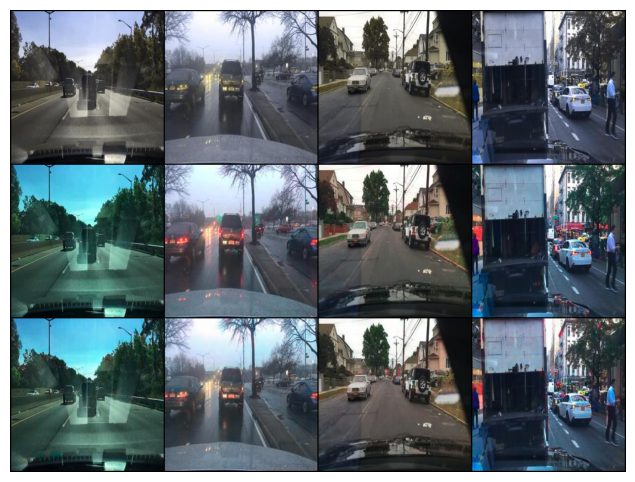

In [ ]:
# ---------------- Test Pix2Pix on Test Set ----------------
import os
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------------- Paths ----------------
TEST_DIR = "/content/pix2pix_dataset_p/test"  # فولدر بيانات الاختبار
CHECKPOINT_GEN = "/content/pix2pix_dataset_p/out/gen_best_p.pth.tar"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
OUTPUT_TEST_DIR = "/content/pix2pix_dataset_p/test_results"
os.makedirs(OUTPUT_TEST_DIR, exist_ok=True)

# ---------------- Dataset ----------------
class MapDatasetTest(torch.utils.data.Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))])
        self.transform = A.Compose([A.Resize(image_size,image_size)], additional_targets={"image0":"image"})
        self.to_tensor = A.Compose([A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)), ToTensorV2()])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        augmented = self.transform(image=input_image, image0=target_image)
        inp = self.to_tensor(image=augmented["image"])["image"]
        tar = self.to_tensor(image=augmented["image0"])["image"]
        return inp, tar, self.files[idx]

# ---------------- Generator ----------------
class U_NetBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False,use_instancenorm=True):
        super().__init__()
        norm = torch.nn.InstanceNorm2d if use_instancenorm else torch.nn.BatchNorm2d
        if down:
            layers=[torch.nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode="reflect"),
                    norm(out_channels),
                    torch.nn.LeakyReLU(0.2) if act=="leaky" else torch.nn.ReLU()]
        else:
            layers=[torch.nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
                    norm(out_channels),
                    torch.nn.ReLU() if act=="relu" else torch.nn.LeakyReLU(0.2)]
        self.conv = torch.nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)
    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(torch.nn.Conv2d(in_channels,features,4,2,1), torch.nn.LeakyReLU(0.2))
        self.down1 = U_NetBlock(features,features*2,down=True,act="leaky")
        self.down2 = U_NetBlock(features*2,features*4,down=True,act="leaky")
        self.down3 = U_NetBlock(features*4,features*8,down=True,act="leaky")
        self.down4 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down5 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down6 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck = torch.nn.Sequential(torch.nn.Conv2d(features*8,features*8,4,2,1), torch.nn.ReLU())
        self.up1 = U_NetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up3 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up4 = U_NetBlock(features*8*2,features*8,down=False,act="relu")
        self.up5 = U_NetBlock(features*8*2,features*4,down=False,act="relu")
        self.up6 = U_NetBlock(features*4*2,features*2,down=False,act="relu")
        self.up7 = U_NetBlock(features*2*2,features,down=False,act="relu")
        self.final_up = torch.nn.Sequential(torch.nn.ConvTranspose2d(features*2,in_channels,4,2,1), torch.nn.Tanh())
    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Load Model ----------------
gen = Generator().to(DEVICE)
checkpoint = torch.load(CHECKPOINT_GEN, map_location=DEVICE)
gen.load_state_dict(checkpoint["state_dict"])
gen.eval()
print("✅ Model loaded successfully!")

# ---------------- Load Test Data ----------------
test_dataset = MapDatasetTest(TEST_DIR)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ---------------- Run Test & Save Results ----------------
for i, (x, y, fname) in enumerate(test_loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        y_fake = gen(x)
    # Save images
    for b in range(x.shape[0]):
        input_img = (x[b]*0.5+0.5).clamp(0,1)
        target_img = (y[b]*0.5+0.5).clamp(0,1)
        gen_img = (y_fake[b]*0.5+0.5).clamp(0,1)
        # حفظ كل صورة
        save_image(input_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_input.png"))
        save_image(target_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_target.png"))
        save_image(gen_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_gen.png"))
    if i==0:  # عرض أول batch
        grid = make_grid(torch.cat([x[:4], y[:4], y_fake[:4]], dim=0)*0.5+0.5, nrow=4)
        plt.figure(figsize=(12,6))
        plt.imshow(grid.permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.show()


✅ Model loaded successfully!


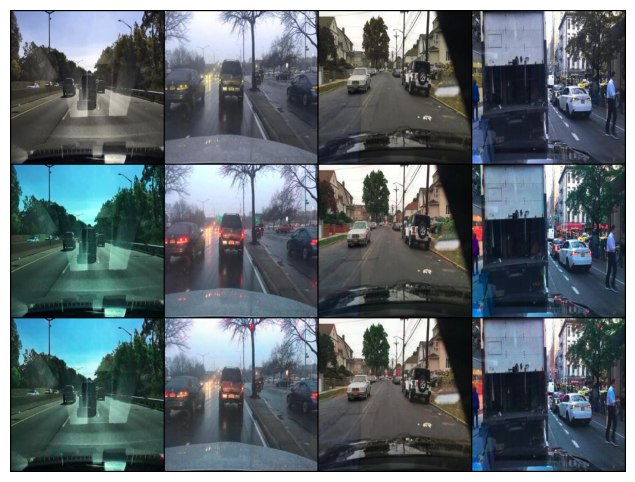

KeyboardInterrupt: 

In [ ]:
# ---------------- Test Pix2Pix on Test Set ----------------
import os
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---------------- Paths ----------------
TEST_DIR = "/content/pix2pix_dataset_p/test"  # فولدر بيانات الاختبار
CHECKPOINT_GEN = "/content/drive/MyDrive/pix2pix_result_p/gen_final_p.pth.tar"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
OUTPUT_TEST_DIR = "/content/pix2pix_dataset_p/test_results2"
os.makedirs(OUTPUT_TEST_DIR, exist_ok=True)

# ---------------- Dataset ----------------
class MapDatasetTest(torch.utils.data.Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))])
        self.transform = A.Compose([A.Resize(image_size,image_size)], additional_targets={"image0":"image"})
        self.to_tensor = A.Compose([A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)), ToTensorV2()])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        augmented = self.transform(image=input_image, image0=target_image)
        inp = self.to_tensor(image=augmented["image"])["image"]
        tar = self.to_tensor(image=augmented["image0"])["image"]
        return inp, tar, self.files[idx]

# ---------------- Generator ----------------
class U_NetBlock(torch.nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act="relu",use_dropout=False,use_instancenorm=True):
        super().__init__()
        norm = torch.nn.InstanceNorm2d if use_instancenorm else torch.nn.BatchNorm2d
        if down:
            layers=[torch.nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode="reflect"),
                    norm(out_channels),
                    torch.nn.LeakyReLU(0.2) if act=="leaky" else torch.nn.ReLU()]
        else:
            layers=[torch.nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
                    norm(out_channels),
                    torch.nn.ReLU() if act=="relu" else torch.nn.LeakyReLU(0.2)]
        self.conv = torch.nn.Sequential(*layers)
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)
    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(torch.nn.Conv2d(in_channels,features,4,2,1), torch.nn.LeakyReLU(0.2))
        self.down1 = U_NetBlock(features,features*2,down=True,act="leaky")
        self.down2 = U_NetBlock(features*2,features*4,down=True,act="leaky")
        self.down3 = U_NetBlock(features*4,features*8,down=True,act="leaky")
        self.down4 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down5 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.down6 = U_NetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck = torch.nn.Sequential(torch.nn.Conv2d(features*8,features*8,4,2,1), torch.nn.ReLU())
        self.up1 = U_NetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up3 = U_NetBlock(features*8*2,features*8,down=False,act="relu",use_dropout=True)
        self.up4 = U_NetBlock(features*8*2,features*8,down=False,act="relu")
        self.up5 = U_NetBlock(features*8*2,features*4,down=False,act="relu")
        self.up6 = U_NetBlock(features*4*2,features*2,down=False,act="relu")
        self.up7 = U_NetBlock(features*2*2,features,down=False,act="relu")
        self.final_up = torch.nn.Sequential(torch.nn.ConvTranspose2d(features*2,in_channels,4,2,1), torch.nn.Tanh())
    def forward(self,x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],dim=1))
        up3 = self.up3(torch.cat([up2,d6],dim=1))
        up4 = self.up4(torch.cat([up3,d5],dim=1))
        up5 = self.up5(torch.cat([up4,d4],dim=1))
        up6 = self.up6(torch.cat([up5,d3],dim=1))
        up7 = self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Load Model ----------------
gen = Generator().to(DEVICE)
checkpoint = torch.load(CHECKPOINT_GEN, map_location=DEVICE)
gen.load_state_dict(checkpoint["state_dict"])
gen.eval()
print("✅ Model loaded successfully!")

# ---------------- Load Test Data ----------------
test_dataset = MapDatasetTest(TEST_DIR)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ---------------- Run Test & Save Results ----------------
for i, (x, y, fname) in enumerate(test_loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
    with torch.no_grad():
        y_fake = gen(x)
    # Save images
    for b in range(x.shape[0]):
        input_img = (x[b]*0.5+0.5).clamp(0,1)
        target_img = (y[b]*0.5+0.5).clamp(0,1)
        gen_img = (y_fake[b]*0.5+0.5).clamp(0,1)
        # حفظ كل صورة
        save_image(input_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_input.png"))
        save_image(target_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_target.png"))
        save_image(gen_img, os.path.join(OUTPUT_TEST_DIR, f"{fname[b]}_gen.png"))
    if i==0:  # عرض أول batch
        grid = make_grid(torch.cat([x[:4], y[:4], y_fake[:4]], dim=0)*0.5+0.5, nrow=4)
        plt.figure(figsize=(12,6))
        plt.imshow(grid.permute(1,2,0).cpu().numpy())
        plt.axis("off")
        plt.show()


In [ ]:
# evaluate_pix2pix_drive.py
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive


GDRIVE_DIR = "/content/pix2pix_dataset_p/out"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 الجهاز المستخدم:", DEVICE)

# ---------------- إعداد المسارات ----------------
TEST_DIR = "/content/pix2pix_dataset_p/test"
OUTPUT_DIR = "/content/pix2pix_dataset_p/test_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CHECKPOINT_GEN = os.path.join(GDRIVE_DIR, "gen_best_p.pth.tar")

# ---------------- Dataset ----------------
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, image_size=256):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        self.transform = A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), max_pixel_value=255.0),
            ToTensorV2(),
        ])
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = np.array(Image.open(img_path).convert("RGB"))
        w = img.shape[1] // 2
        input_image = img[:, :w, :]
        target_image = img[:, w:, :]
        return self.transform(image=input_image)["image"], self.transform(image=target_image)["image"], self.files[idx]

# ---------------- Generator ----------------
class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(torch.nn.Conv2d(in_channels,features,4,2,1), torch.nn.LeakyReLU(0.2))
        self.down1 = self.block(features,features*2)
        self.down2 = self.block(features*2,features*4)
        self.down3 = self.block(features*4,features*8)
        self.down4 = self.block(features*8,features*8)
        self.down5 = self.block(features*8,features*8)
        self.down6 = self.block(features*8,features*8)
        self.bottleneck = torch.nn.Sequential(torch.nn.Conv2d(features*8,features*8,4,2,1), torch.nn.ReLU())
        self.up1 = self.up_block(features*8,features*8,dropout=True)
        self.up2 = self.up_block(features*8*2,features*8,dropout=True)
        self.up3 = self.up_block(features*8*2,features*8,dropout=True)
        self.up4 = self.up_block(features*8*2,features*8)
        self.up5 = self.up_block(features*8*2,features*4)
        self.up6 = self.up_block(features*4*2,features*2)
        self.up7 = self.up_block(features*2*2,features)
        self.final_up = torch.nn.Sequential(torch.nn.ConvTranspose2d(features*2,in_channels,4,2,1), torch.nn.Tanh())
    def block(self,in_c,out_c):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_c,out_c,4,2,1,bias=False),
            torch.nn.InstanceNorm2d(out_c),
            torch.nn.LeakyReLU(0.2)
        )
    def up_block(self,in_c,out_c,dropout=False):
        layers=[torch.nn.ConvTranspose2d(in_c,out_c,4,2,1,bias=False),
                torch.nn.InstanceNorm2d(out_c),
                torch.nn.ReLU()]
        if dropout: layers.append(torch.nn.Dropout(0.5))
        return torch.nn.Sequential(*layers)
    def forward(self,x):
        d1=self.initial_down(x); d2=self.down1(d1); d3=self.down2(d2)
        d4=self.down3(d3); d5=self.down4(d4); d6=self.down5(d5); d7=self.down6(d6)
        b=self.bottleneck(d7)
        up1=self.up1(b); up2=self.up2(torch.cat([up1,d7],dim=1))
        up3=self.up3(torch.cat([up2,d6],dim=1))
        up4=self.up4(torch.cat([up3,d5],dim=1))
        up5=self.up5(torch.cat([up4,d4],dim=1))
        up6=self.up6(torch.cat([up5,d3],dim=1))
        up7=self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))

# ---------------- Evaluation ----------------
def evaluate_model():
    dataset = MapDataset(TEST_DIR)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model = Generator().to(DEVICE)
    ckpt = torch.load(CHECKPOINT_GEN, map_location=DEVICE)
    state_dict = ckpt["state_dict"]

    # تعديل أسماء المفاتيح لتتوافق مع الـ model الحالي
    new_state_dict = {}
    for k, v in state_dict.items():
        new_k = k.replace(".conv", "")  # نحذف ".conv" من كل اسم مفتاح
        new_state_dict[new_k] = v

    missing, unexpected = model.load_state_dict(new_state_dict, strict=False)
    print("✅ تم تحميل checkpoint بعد تعديل الأسماء.")
    if missing:
        print("⚠️ مفاتيح ناقصة:", missing)
    if unexpected:
        print("⚠️ مفاتيح غير متوقعة:", unexpected)

    model.eval()

    L1 = torch.nn.L1Loss()
    total_l1 = 0
    with torch.no_grad():
        for i,(x,y,name) in enumerate(tqdm(loader, desc="🔍 Evaluating")):
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_fake = model(x)
            l1 = L1(y_fake, y).item()
            total_l1 += l1
            # حفظ أول 20 صورة فقط للمقارنة
            if i < 20:
                comp = torch.cat([x*0.5+0.5, y*0.5+0.5, y_fake*0.5+0.5], dim=3)
                save_image(comp, os.path.join(OUTPUT_DIR, f"sample_{i+1}_{name[0]}"))
    avg_l1 = total_l1 / len(loader)
    print(f"\n📊 متوسط فرق L1 على بيانات الاختبار: {avg_l1:.6f}")
    if avg_l1 < 0.05:
        print("✅ أداء الموديل ممتاز على التيست!")
    elif avg_l1 < 0.1:
        print("⚖️ أداء جيد لكن يحتاج تحسين بسيط.")
    else:
        print("❌ أداء ضعيف، الموديل محتاج إعادة تدريب.")
    return avg_l1

if __name__ == "__main__":
    evaluate_model()


🚀 الجهاز المستخدم: cuda
✅ تم تحميل checkpoint بعد تعديل الأسماء.
⚠️ مفاتيح غير متوقعة: ['down1.0.bias', 'down2.0.bias', 'down3.0.bias', 'down4.0.bias', 'down5.0.bias', 'down6.0.bias', 'up1.0.bias', 'up2.0.bias', 'up3.0.bias', 'up4.0.bias', 'up5.0.bias', 'up6.0.bias', 'up7.0.bias']


🔍 Evaluating: 100%|██████████| 1638/1638 [00:20<00:00, 81.78it/s]


📊 متوسط فرق L1 على بيانات الاختبار: 0.047127
✅ أداء الموديل ممتاز على التيست!


In [ ]:
# حفظ الموديل مؤقتًا في مساحة Colab
import torch

torch.save(generator.state_dict(), "model_pix2pix_final.pth")
print("✅ تم حفظ الموديل مؤقتًا باسم model_pix2pix_final.pth")
